# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import model
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import gc

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 5e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../../Cholec8k/*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../../Cholec8k/*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)

scaler = torch.cuda.amp.GradScaler(enabled=True)

iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

In [13]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
start_timer()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		with torch.autocast(device_type=DEVICE, dtype=torch.float16):
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		scaler.scale(loss).backward()
		scaler.step(opt)
		opt.zero_grad()
		scaler.update()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformerAMP_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
end_timer_and_print("Mixed precision:")
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\cuda\memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


[INFO] training the network...


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 1/100
Train loss: 0.527232, Test loss: 0.3226, Train IoU: 0.3194, Test IoU: 0.5135, Train Dice: 0.4678, Test Dice: 0.6774
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 2/100
Train loss: 0.260149, Test loss: 0.2050, Train IoU: 0.5867, Test IoU: 0.6629, Train Dice: 0.7349, Test Dice: 0.7950
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 3/100
Train loss: 0.194097, Test loss: 0.1867, Train IoU: 0.6727, Test IoU: 0.6878, Train Dice: 0.8010, Test Dice: 0.8133
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 4/100
Train loss: 0.180830, Test loss: 0.1755, Train IoU: 0.6909, Test IoU: 0.7034, Train Dice: 0.8142, Test Dice: 0.8245
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 5/100
Train loss: 0.174989, Test loss: 0.1741, Train IoU: 0.6990, Test IoU: 0.7050, Train Dice: 0.8201, Test Dice: 0.8259
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 6/100
Train loss: 0.170884, Test loss: 0.1706, Train IoU: 0.7048, Test IoU: 0.7101, Train Dice: 0.8242, Test Dice: 0.8294
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 7/100
Train loss: 0.168788, Test loss: 0.1676, Train IoU: 0.7077, Test IoU: 0.7144, Train Dice: 0.8263, Test Dice: 0.8324
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  2.00it/s]


[INFO] EPOCH: 8/100
Train loss: 0.166672, Test loss: 0.1664, Train IoU: 0.7108, Test IoU: 0.7160, Train Dice: 0.8284, Test Dice: 0.8336
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 9/100
Train loss: 0.166118, Test loss: 0.1652, Train IoU: 0.7115, Test IoU: 0.7177, Train Dice: 0.8290, Test Dice: 0.8348
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 10/100
Train loss: 0.164560, Test loss: 0.1648, Train IoU: 0.7137, Test IoU: 0.7183, Train Dice: 0.8305, Test Dice: 0.8352
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 11/100
Train loss: 0.164073, Test loss: 0.1658, Train IoU: 0.7144, Test IoU: 0.7167, Train Dice: 0.8310, Test Dice: 0.8342


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 12/100
Train loss: 0.163137, Test loss: 0.1640, Train IoU: 0.7156, Test IoU: 0.7194, Train Dice: 0.8319, Test Dice: 0.8360
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 13/100
Train loss: 0.162470, Test loss: 0.1629, Train IoU: 0.7167, Test IoU: 0.7210, Train Dice: 0.8326, Test Dice: 0.8371
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


[INFO] EPOCH: 14/100
Train loss: 0.162251, Test loss: 0.1633, Train IoU: 0.7170, Test IoU: 0.7203, Train Dice: 0.8328, Test Dice: 0.8367


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 15/100
Train loss: 0.148962, Test loss: 0.1146, Train IoU: 0.7379, Test IoU: 0.7961, Train Dice: 0.8461, Test Dice: 0.8854
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 16/100
Train loss: 0.107366, Test loss: 0.1062, Train IoU: 0.8028, Test IoU: 0.8093, Train Dice: 0.8877, Test Dice: 0.8938
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 17/100
Train loss: 0.102684, Test loss: 0.1029, Train IoU: 0.8102, Test IoU: 0.8147, Train Dice: 0.8924, Test Dice: 0.8971
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 18/100
Train loss: 0.094421, Test loss: 0.0902, Train IoU: 0.8243, Test IoU: 0.8359, Train Dice: 0.9007, Test Dice: 0.9098
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 19/100
Train loss: 0.087534, Test loss: 0.0873, Train IoU: 0.8354, Test IoU: 0.8406, Train Dice: 0.9075, Test Dice: 0.9127
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 20/100
Train loss: 0.086061, Test loss: 0.0866, Train IoU: 0.8377, Test IoU: 0.8417, Train Dice: 0.9090, Test Dice: 0.9134
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 21/100
Train loss: 0.085034, Test loss: 0.0859, Train IoU: 0.8394, Test IoU: 0.8428, Train Dice: 0.9100, Test Dice: 0.9141
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 22/100
Train loss: 0.083603, Test loss: 0.0843, Train IoU: 0.8418, Test IoU: 0.8455, Train Dice: 0.9115, Test Dice: 0.9157
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 23/100
Train loss: 0.082843, Test loss: 0.0834, Train IoU: 0.8430, Test IoU: 0.8470, Train Dice: 0.9122, Test Dice: 0.9166
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 24/100
Train loss: 0.082380, Test loss: 0.0828, Train IoU: 0.8438, Test IoU: 0.8480, Train Dice: 0.9127, Test Dice: 0.9172
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 25/100
Train loss: 0.081776, Test loss: 0.0828, Train IoU: 0.8448, Test IoU: 0.8479, Train Dice: 0.9133, Test Dice: 0.9172


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 26/100
Train loss: 0.081141, Test loss: 0.0820, Train IoU: 0.8458, Test IoU: 0.8492, Train Dice: 0.9139, Test Dice: 0.9180
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 27/100
Train loss: 0.080850, Test loss: 0.0822, Train IoU: 0.8464, Test IoU: 0.8489, Train Dice: 0.9142, Test Dice: 0.9178


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 28/100
Train loss: 0.082937, Test loss: 0.0830, Train IoU: 0.8428, Test IoU: 0.8474, Train Dice: 0.9121, Test Dice: 0.9170


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 29/100
Train loss: 0.080666, Test loss: 0.0816, Train IoU: 0.8465, Test IoU: 0.8499, Train Dice: 0.9144, Test Dice: 0.9184
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 30/100
Train loss: 0.079775, Test loss: 0.0811, Train IoU: 0.8481, Test IoU: 0.8508, Train Dice: 0.9153, Test Dice: 0.9189
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 31/100
Train loss: 0.079706, Test loss: 0.0812, Train IoU: 0.8482, Test IoU: 0.8506, Train Dice: 0.9154, Test Dice: 0.9188


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 32/100
Train loss: 0.079338, Test loss: 0.0813, Train IoU: 0.8488, Test IoU: 0.8504, Train Dice: 0.9157, Test Dice: 0.9187


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 33/100
Train loss: 0.079090, Test loss: 0.0810, Train IoU: 0.8492, Test IoU: 0.8510, Train Dice: 0.9160, Test Dice: 0.9190
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 34/100
Train loss: 0.078885, Test loss: 0.0809, Train IoU: 0.8496, Test IoU: 0.8511, Train Dice: 0.9162, Test Dice: 0.9191
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 35/100
Train loss: 0.079062, Test loss: 0.0802, Train IoU: 0.8492, Test IoU: 0.8521, Train Dice: 0.9160, Test Dice: 0.9198
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 36/100
Train loss: 0.078981, Test loss: 0.0806, Train IoU: 0.8494, Test IoU: 0.8515, Train Dice: 0.9161, Test Dice: 0.9194


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 37/100
Train loss: 0.079284, Test loss: 0.0801, Train IoU: 0.8488, Test IoU: 0.8524, Train Dice: 0.9158, Test Dice: 0.9199
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 38/100
Train loss: 0.078509, Test loss: 0.0796, Train IoU: 0.8501, Test IoU: 0.8531, Train Dice: 0.9166, Test Dice: 0.9204
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 39/100
Train loss: 0.078157, Test loss: 0.0793, Train IoU: 0.8508, Test IoU: 0.8537, Train Dice: 0.9169, Test Dice: 0.9207
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 40/100
Train loss: 0.073098, Test loss: 0.0709, Train IoU: 0.8597, Test IoU: 0.8685, Train Dice: 0.9220, Test Dice: 0.9291
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 41/100
Train loss: 0.065790, Test loss: 0.0676, Train IoU: 0.8725, Test IoU: 0.8744, Train Dice: 0.9293, Test Dice: 0.9324
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 42/100
Train loss: 0.063262, Test loss: 0.0649, Train IoU: 0.8769, Test IoU: 0.8790, Train Dice: 0.9318, Test Dice: 0.9351
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 43/100
Train loss: 0.060968, Test loss: 0.0605, Train IoU: 0.8810, Test IoU: 0.8869, Train Dice: 0.9341, Test Dice: 0.9395
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 44/100
Train loss: 0.058690, Test loss: 0.0597, Train IoU: 0.8851, Test IoU: 0.8881, Train Dice: 0.9364, Test Dice: 0.9403
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 45/100
Train loss: 0.057354, Test loss: 0.0589, Train IoU: 0.8874, Test IoU: 0.8897, Train Dice: 0.9377, Test Dice: 0.9411
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 46/100
Train loss: 0.056154, Test loss: 0.0576, Train IoU: 0.8895, Test IoU: 0.8920, Train Dice: 0.9389, Test Dice: 0.9424
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 47/100
Train loss: 0.056360, Test loss: 0.0578, Train IoU: 0.8892, Test IoU: 0.8915, Train Dice: 0.9387, Test Dice: 0.9422


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 48/100
Train loss: 0.055533, Test loss: 0.0573, Train IoU: 0.8906, Test IoU: 0.8925, Train Dice: 0.9395, Test Dice: 0.9427
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 49/100
Train loss: 0.055382, Test loss: 0.0575, Train IoU: 0.8909, Test IoU: 0.8921, Train Dice: 0.9397, Test Dice: 0.9425


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 50/100
Train loss: 0.055131, Test loss: 0.0570, Train IoU: 0.8913, Test IoU: 0.8929, Train Dice: 0.9399, Test Dice: 0.9430
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 51/100
Train loss: 0.054676, Test loss: 0.0568, Train IoU: 0.8922, Test IoU: 0.8932, Train Dice: 0.9404, Test Dice: 0.9432
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 52/100
Train loss: 0.054954, Test loss: 0.0572, Train IoU: 0.8917, Test IoU: 0.8926, Train Dice: 0.9401, Test Dice: 0.9428


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 53/100
Train loss: 0.054749, Test loss: 0.0565, Train IoU: 0.8919, Test IoU: 0.8937, Train Dice: 0.9403, Test Dice: 0.9435
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 54/100
Train loss: 0.054047, Test loss: 0.0562, Train IoU: 0.8932, Test IoU: 0.8944, Train Dice: 0.9410, Test Dice: 0.9438
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 55/100
Train loss: 0.054296, Test loss: 0.0563, Train IoU: 0.8928, Test IoU: 0.8942, Train Dice: 0.9408, Test Dice: 0.9437


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 56/100
Train loss: 0.054901, Test loss: 0.0589, Train IoU: 0.8917, Test IoU: 0.8896, Train Dice: 0.9402, Test Dice: 0.9411


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 57/100
Train loss: 0.054618, Test loss: 0.0562, Train IoU: 0.8922, Test IoU: 0.8943, Train Dice: 0.9405, Test Dice: 0.9438


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 58/100
Train loss: 0.053624, Test loss: 0.0557, Train IoU: 0.8939, Test IoU: 0.8952, Train Dice: 0.9414, Test Dice: 0.9443
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 59/100
Train loss: 0.053167, Test loss: 0.0556, Train IoU: 0.8947, Test IoU: 0.8954, Train Dice: 0.9419, Test Dice: 0.9444
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 60/100
Train loss: 0.053346, Test loss: 0.0557, Train IoU: 0.8945, Test IoU: 0.8951, Train Dice: 0.9417, Test Dice: 0.9443


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 61/100
Train loss: 0.053473, Test loss: 0.0559, Train IoU: 0.8942, Test IoU: 0.8949, Train Dice: 0.9416, Test Dice: 0.9441


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 62/100
Train loss: 0.053289, Test loss: 0.0559, Train IoU: 0.8945, Test IoU: 0.8948, Train Dice: 0.9418, Test Dice: 0.9441


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 63/100
Train loss: 0.053467, Test loss: 0.0561, Train IoU: 0.8942, Test IoU: 0.8945, Train Dice: 0.9416, Test Dice: 0.9439


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 64/100
Train loss: 0.054186, Test loss: 0.0576, Train IoU: 0.8929, Test IoU: 0.8918, Train Dice: 0.9409, Test Dice: 0.9424


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 65/100
Train loss: 0.053748, Test loss: 0.0555, Train IoU: 0.8937, Test IoU: 0.8955, Train Dice: 0.9413, Test Dice: 0.9445
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 66/100
Train loss: 0.052758, Test loss: 0.0553, Train IoU: 0.8955, Test IoU: 0.8960, Train Dice: 0.9423, Test Dice: 0.9447
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.95it/s]


[INFO] EPOCH: 67/100
Train loss: 0.052472, Test loss: 0.0556, Train IoU: 0.8960, Test IoU: 0.8953, Train Dice: 0.9426, Test Dice: 0.9444


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 68/100
Train loss: 0.052621, Test loss: 0.0551, Train IoU: 0.8957, Test IoU: 0.8962, Train Dice: 0.9425, Test Dice: 0.9449
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.94it/s]


[INFO] EPOCH: 69/100
Train loss: 0.052652, Test loss: 0.0553, Train IoU: 0.8956, Test IoU: 0.8960, Train Dice: 0.9424, Test Dice: 0.9447


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 70/100
Train loss: 0.052834, Test loss: 0.0555, Train IoU: 0.8953, Test IoU: 0.8955, Train Dice: 0.9422, Test Dice: 0.9445


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 71/100
Train loss: 0.052375, Test loss: 0.0549, Train IoU: 0.8961, Test IoU: 0.8966, Train Dice: 0.9427, Test Dice: 0.9451
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 72/100
Train loss: 0.052420, Test loss: 0.0552, Train IoU: 0.8961, Test IoU: 0.8961, Train Dice: 0.9427, Test Dice: 0.9448


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 73/100
Train loss: 0.053031, Test loss: 0.0554, Train IoU: 0.8950, Test IoU: 0.8957, Train Dice: 0.9420, Test Dice: 0.9446


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 74/100
Train loss: 0.052593, Test loss: 0.0551, Train IoU: 0.8957, Test IoU: 0.8962, Train Dice: 0.9425, Test Dice: 0.9449


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 75/100
Train loss: 0.052504, Test loss: 0.0553, Train IoU: 0.8959, Test IoU: 0.8958, Train Dice: 0.9426, Test Dice: 0.9447


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 76/100
Train loss: 0.052186, Test loss: 0.0549, Train IoU: 0.8964, Test IoU: 0.8967, Train Dice: 0.9429, Test Dice: 0.9451
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 77/100
Train loss: 0.052119, Test loss: 0.0551, Train IoU: 0.8965, Test IoU: 0.8962, Train Dice: 0.9430, Test Dice: 0.9449


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 78/100
Train loss: 0.052194, Test loss: 0.0551, Train IoU: 0.8964, Test IoU: 0.8963, Train Dice: 0.9429, Test Dice: 0.9449


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 79/100
Train loss: 0.052019, Test loss: 0.0548, Train IoU: 0.8968, Test IoU: 0.8967, Train Dice: 0.9431, Test Dice: 0.9452
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:43<00:00,  1.96it/s]


[INFO] EPOCH: 80/100
Train loss: 0.052034, Test loss: 0.0549, Train IoU: 0.8968, Test IoU: 0.8966, Train Dice: 0.9430, Test Dice: 0.9451


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 81/100
Train loss: 0.051727, Test loss: 0.0549, Train IoU: 0.8972, Test IoU: 0.8966, Train Dice: 0.9433, Test Dice: 0.9451


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 82/100
Train loss: 0.051943, Test loss: 0.0545, Train IoU: 0.8969, Test IoU: 0.8973, Train Dice: 0.9431, Test Dice: 0.9455
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 83/100
Train loss: 0.051865, Test loss: 0.0547, Train IoU: 0.8970, Test IoU: 0.8969, Train Dice: 0.9432, Test Dice: 0.9453


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 84/100
Train loss: 0.054285, Test loss: 0.0564, Train IoU: 0.8927, Test IoU: 0.8940, Train Dice: 0.9408, Test Dice: 0.9436


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 85/100
Train loss: 0.052979, Test loss: 0.0548, Train IoU: 0.8950, Test IoU: 0.8968, Train Dice: 0.9421, Test Dice: 0.9452


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 86/100
Train loss: 0.051537, Test loss: 0.0544, Train IoU: 0.8976, Test IoU: 0.8975, Train Dice: 0.9435, Test Dice: 0.9456
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 87/100
Train loss: 0.051289, Test loss: 0.0543, Train IoU: 0.8981, Test IoU: 0.8977, Train Dice: 0.9438, Test Dice: 0.9457
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 88/100
Train loss: 0.051281, Test loss: 0.0545, Train IoU: 0.8981, Test IoU: 0.8972, Train Dice: 0.9438, Test Dice: 0.9455


100%|██████████| 202/202 [01:42<00:00,  1.96it/s]


[INFO] EPOCH: 89/100
Train loss: 0.051261, Test loss: 0.0545, Train IoU: 0.8981, Test IoU: 0.8973, Train Dice: 0.9438, Test Dice: 0.9455


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 90/100
Train loss: 0.051107, Test loss: 0.0542, Train IoU: 0.8984, Test IoU: 0.8978, Train Dice: 0.9440, Test Dice: 0.9458
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 91/100
Train loss: 0.051169, Test loss: 0.0541, Train IoU: 0.8982, Test IoU: 0.8980, Train Dice: 0.9439, Test Dice: 0.9459
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 92/100
Train loss: 0.051111, Test loss: 0.0546, Train IoU: 0.8984, Test IoU: 0.8971, Train Dice: 0.9440, Test Dice: 0.9454


100%|██████████| 202/202 [01:42<00:00,  1.98it/s]


[INFO] EPOCH: 93/100
Train loss: 0.051407, Test loss: 0.0544, Train IoU: 0.8979, Test IoU: 0.8975, Train Dice: 0.9437, Test Dice: 0.9456


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 94/100
Train loss: 0.051179, Test loss: 0.0543, Train IoU: 0.8983, Test IoU: 0.8977, Train Dice: 0.9439, Test Dice: 0.9457


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 95/100
Train loss: 0.052107, Test loss: 0.0550, Train IoU: 0.8967, Test IoU: 0.8963, Train Dice: 0.9430, Test Dice: 0.9450


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 96/100
Train loss: 0.051631, Test loss: 0.0544, Train IoU: 0.8974, Test IoU: 0.8975, Train Dice: 0.9434, Test Dice: 0.9456


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 97/100
Train loss: 0.051146, Test loss: 0.0543, Train IoU: 0.8983, Test IoU: 0.8977, Train Dice: 0.9439, Test Dice: 0.9457


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 98/100
Train loss: 0.051412, Test loss: 0.0548, Train IoU: 0.8979, Test IoU: 0.8967, Train Dice: 0.9437, Test Dice: 0.9452


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 99/100
Train loss: 0.051339, Test loss: 0.0542, Train IoU: 0.8980, Test IoU: 0.8978, Train Dice: 0.9437, Test Dice: 0.9458


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 100/100
Train loss: 0.050809, Test loss: 0.0540, Train IoU: 0.8989, Test IoU: 0.8982, Train Dice: 0.9443, Test Dice: 0.9460
Best IoU improved. Model saved.

Mixed precision:
Total execution time = 12449.602 sec
Max memory used by tensors = 4980365312 bytes
[INFO] total time taken to train the model: 12449.68s
Best IoU is: 0.89824


In [14]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

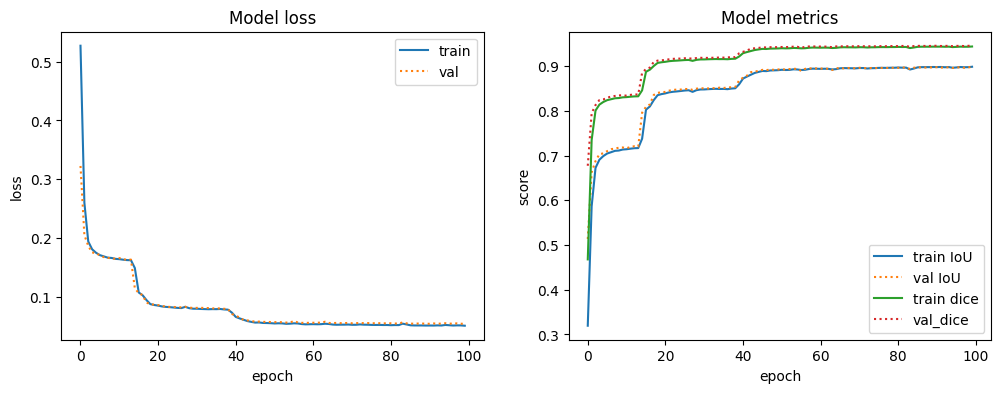

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [16]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [17]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

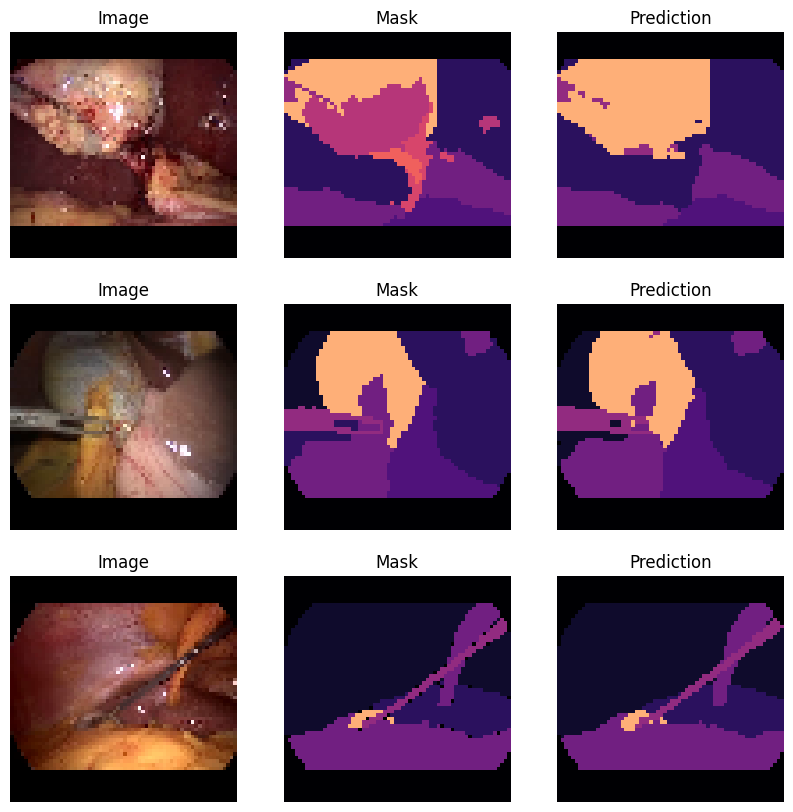

In [18]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota